<a href="https://colab.research.google.com/github/MS12code/Twitter-Sentiment-Analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing kaggle library

! pip install kaggle

In [7]:
#uploaded my kaggle json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [8]:
#importing the twitter sentiment Dataset using api to fetch dataset from kaggle

!kaggle datasets download -d kazanova/sentiment140




Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.23GB/s]


In [9]:
#extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')



The dataset is extracted


Importing the Dependencies

In [10]:
import numpy as nd
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#printing stopwards in English

print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Data Processing

In [13]:
#Loading the data from csv to pandas dataframe

twitter_data =  pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')


In [14]:
#Checking the no of rows and columns

twitter_data.shape

(1599999, 6)

In [15]:
#Printing the first 5 rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [16]:
#Naming the columns and reading the dataset again

column_names = ['target' , 'id' , 'data' , 'flag' , 'user' , 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',names=column_names)

In [17]:
#Checking again the no of rows and columns (no of tweets that we have ~16L Tweets)

twitter_data.shape

(1600000, 6)

In [18]:
twitter_data.head()

,target,id,data,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [19]:
#Count the no of missing values
twitter_data.isnull().sum()

,0
target,0
id,0
data,0
flag,0
user,0
text,0


In [20]:
#Checking the dist. of target column
#How many positive, negative or neutral tweets are present

twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


In [21]:
#Convert the target "4" to "1"

twitter_data.replace({'target':{4:1}},inplace=True)

#checking the dist. again

twitter_data['target'].value_counts()


,count
target,
0,800000
1,800000


0 -> Negative Tweet

1 -> Positive Tweet

**Stemming** = reducing words to its root word

In [22]:
port_stem = PorterStemmer()

In [23]:
def stemming(content):

    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [25]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [26]:
twitter_data.head()

,target,id,data,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [27]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [28]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [30]:
#Seperating the data and label

X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [31]:
print(Y)

[0 0 0 ... 1 1 1]


Splitting the data to training data and test data


In [32]:
X_train , X_test , Y_train , Y_test = train_test_split(X,Y,test_size = 0.2,stratify=Y,random_state=2)

In [33]:
print(X.shape , X_train.shape , X_test.shape)

(1600000,) (1280000,) (320000,)


In [34]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [35]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [36]:
#Converting textual data to Numerical data

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9453092 stored elements and shape (1280000, 461488)>
  Coords	Values
  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (12

In [38]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2289192 stored elements and shape (320000, 461488)>
  Coords	Values
  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538


In [ ]:
#Training the ML Model
#Logistic Regression

In [39]:
model = LogisticRegression(max_iter=1000)

In [40]:
model.fit(X_train , Y_train)

LogisticRegression(max_iter=1000)

In [41]:
#Accuracy score on the training data

X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction , Y_train)

In [44]:
print('Accuracy score on the training data : ' , training_data_accuracy)

Accuracy score on the training data :  0.79871953125


In [45]:
#Accuracy score on the training data

X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test , X_test_prediction)
print("Accuracy score on the test data : " , test_data_accuracy)

Accuracy score on the test data :  0.77668125


Model Accuracy - 77.6%

In [46]:
#saving the trained model

import pickle

In [47]:
filename = 'trained_model.sav'
pickle.dump(model , open(filename,'wb'))

Using the saved model for future predictions

In [49]:
#loading the saved model

loaded_model = pickle.load(open('/content/trained_model.sav' , 'rb'))

In [53]:
X_new = X_test[200]
print(Y_test[200])

prediciton = model.predict(X_new)

print(prediciton)

if (prediciton[0]==0):

    print('Negative Tweet')

else:

    print('Positive Tweet')


1
[1]
Positive Tweet


Sentiment Distribution in Dataset

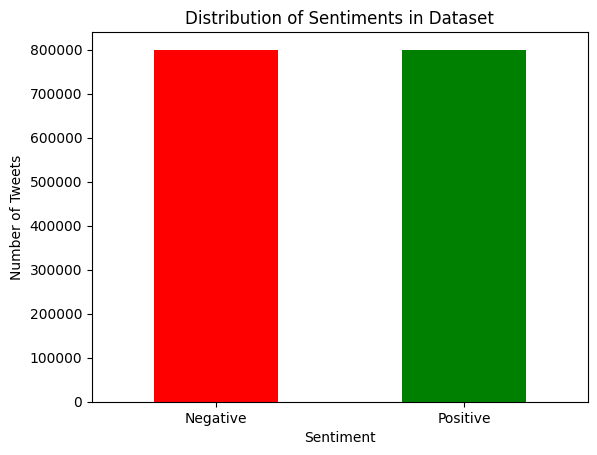

In [54]:
import matplotlib.pyplot as plt

# Visualizing original label distribution
twitter_data['target'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Sentiments in Dataset')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


In [55]:
#Word Cloud of Positive and Negative Tweets

!pip install wordcloud


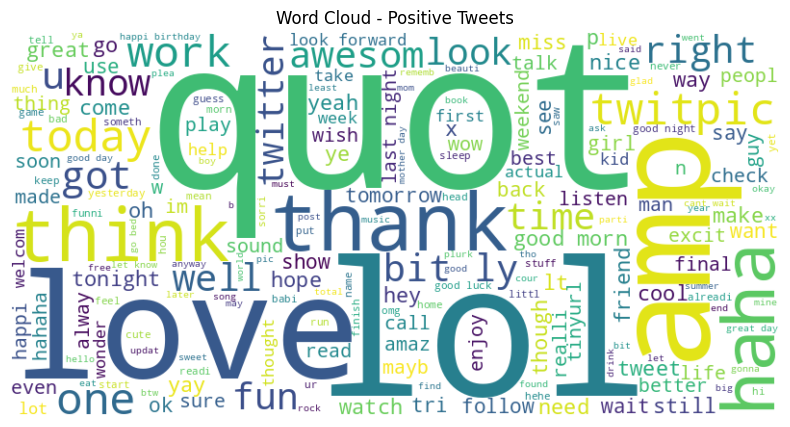

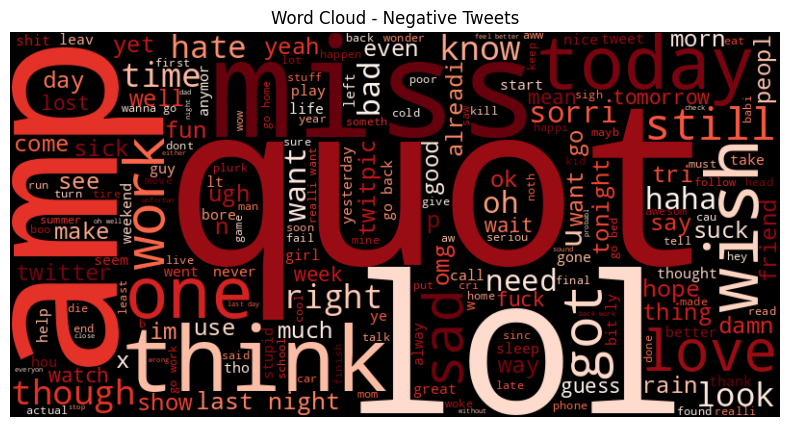

In [56]:
from wordcloud import WordCloud

# Join all stemmed content for each sentiment
positive_text = ' '.join(twitter_data[twitter_data['target'] == 1]['stemmed_content'])
negative_text = ' '.join(twitter_data[twitter_data['target'] == 0]['stemmed_content'])

# Plot Positive Tweet WordCloud
plt.figure(figsize=(10,5))
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Tweets')
plt.show()

# Plot Negative Tweet WordCloud
plt.figure(figsize=(10,5))
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Tweets')
plt.show()


In [57]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 500x500 with 0 Axes>

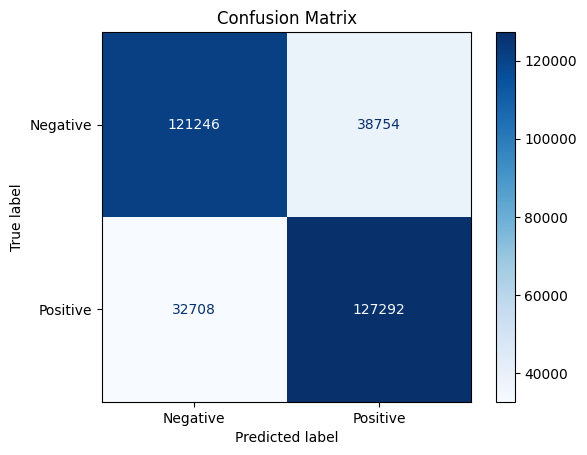

In [58]:
# Use your predicted and actual labels
Y_pred = model.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


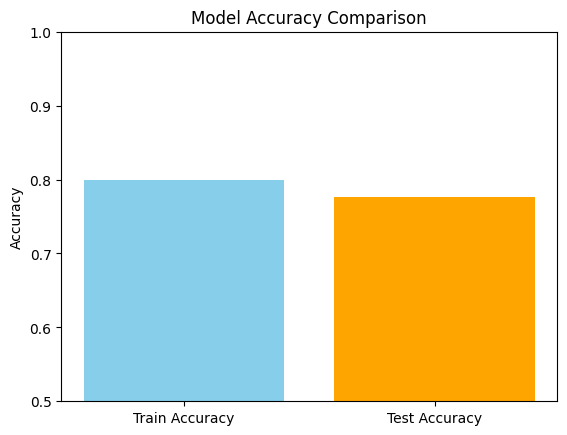

In [59]:
#Accuracy Bar Plot

train_acc = training_data_accuracy
test_acc = accuracy_score(Y_test, model.predict(X_test))

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'orange'])
plt.ylim(0.5, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


In [60]:
#Precision, Recall, F1-score – Classification Report
from sklearn.metrics import classification_report

print("Classification Report (Test Set):\n")
print(classification_report(Y_test, Y_pred, target_names=["Negative", "Positive"]))

Classification Report (Test Set):

              precision    recall  f1-score   support

    Negative       0.79      0.76      0.77    160000
    Positive       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



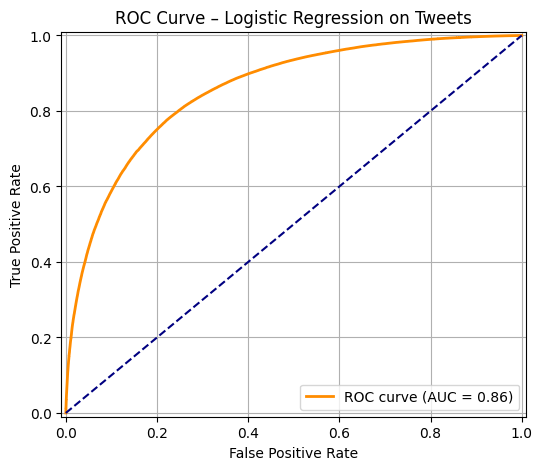

In [61]:
#ROC Curve (Receiver Operating Characteristic)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize target labels (0 and 1) for ROC curve
y_test_bin = label_binarize(Y_test, classes=[0, 1])  # shape: (n_samples, 1)
y_score = model.decision_function(X_test)  # get decision function scores

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression on Tweets')
plt.legend(loc='lower right')
plt.grid()
plt.show()
